In [320]:
ultrasound_file = r"c:\Data\Spine\TestingData_0_512\1130_Sa_LU_vTU_ultrasound.npy"
segmentation_file = r"c:\Data\Spine\TestingData_0_512\1130_Sa_LU_vTU_segmentation.npy"

In [321]:
import numpy as np
np.random.seed(42)

ultrasound_data = np.load(ultrasound_file)
segmentation_data = np.load(segmentation_file)

print(f"ultrasound_data.shape = {ultrasound_data.shape}")
print(f"ultrasound_data.dtype = {ultrasound_data.dtype}")
print(f"ultrasound_data.min = {ultrasound_data.min()}")
print(f"ultrasound_data.max = {ultrasound_data.max()}")

print(f"segmentation_data.shape = {segmentation_data.shape}")
print(f"segmentation_data.dtype = {segmentation_data.dtype}")
print(f"segmentation_data.min = {segmentation_data.min()}")
print(f"segmentation_data.max = {segmentation_data.max()}")

ultrasound_data.shape = (315, 512, 512, 1)
ultrasound_data.dtype = uint8
ultrasound_data.min = 0
ultrasound_data.max = 255
segmentation_data.shape = (315, 512, 512, 1)
segmentation_data.dtype = uint8
segmentation_data.min = 0
segmentation_data.max = 1


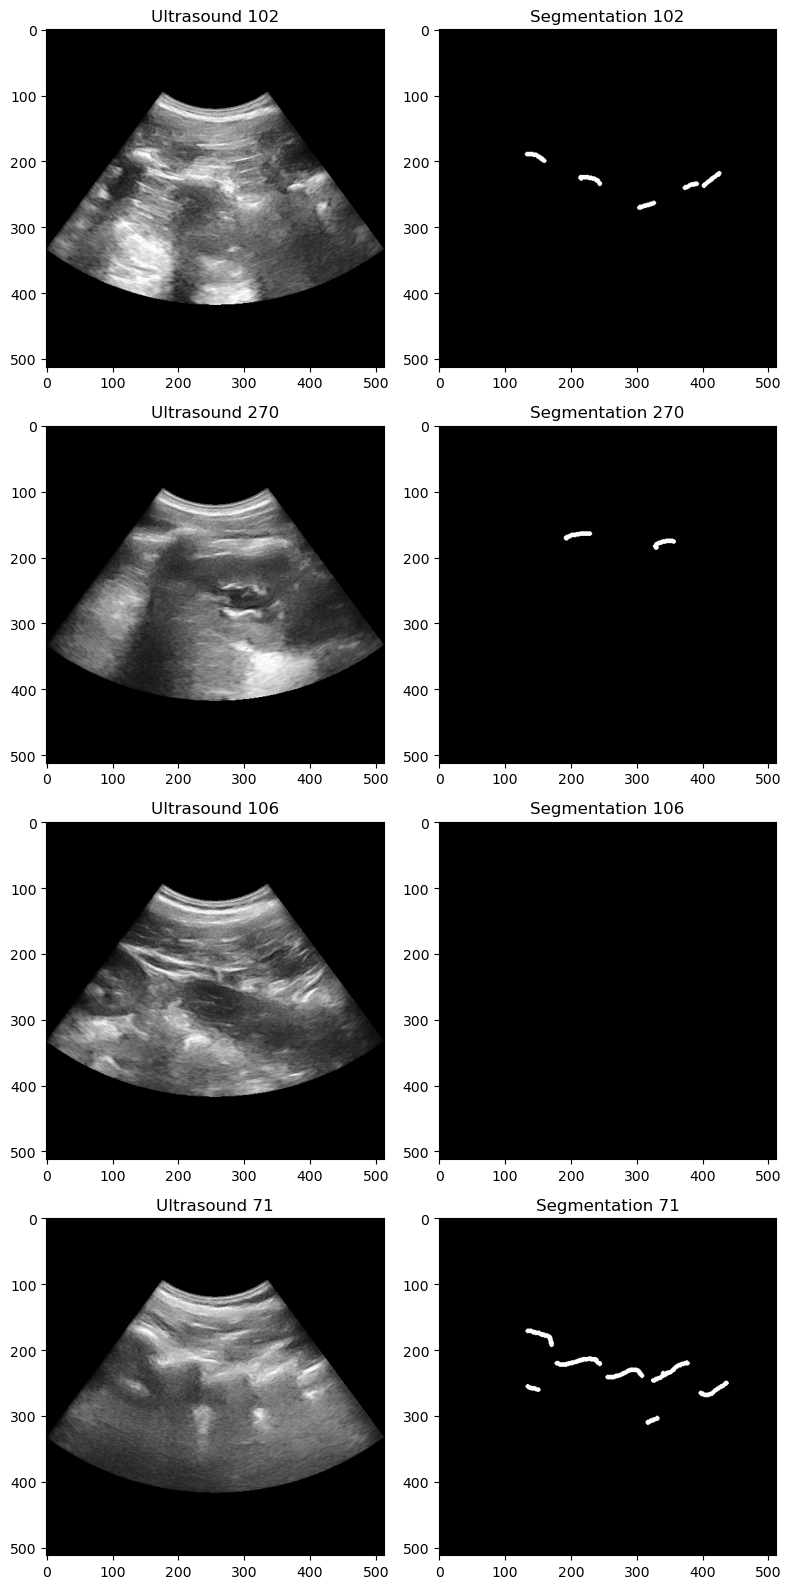

In [322]:
# Show a random sample of ultrasound images and their corresponding segmentations. Ultrasound in the first column and segmentations in the second column.

import matplotlib.pyplot as plt
%matplotlib inline

num_samples = 4
sample_indices = np.random.randint(0, ultrasound_data.shape[0], num_samples)

fig, ax = plt.subplots(num_samples, 2, figsize=(8, 4*num_samples))

for i, sample_index in enumerate(sample_indices):
    ax[i, 0].imshow(ultrasound_data[sample_index, :, :], cmap="gray")
    ax[i, 0].set_title(f"Ultrasound {sample_index}")
    ax[i, 1].imshow(segmentation_data[sample_index, :, :], cmap="gray")
    ax[i, 1].set_title(f"Segmentation {sample_index}")

plt.tight_layout()
plt.show()

In [323]:
# Make a scanconversion_config dictionary

scanconversion_config = {
    "num_lines": 128,
    "num_samples_along_lines": 128,
    "curvilinear_image_size": 512,
    "center_coordinate_pixel": (0, 256),
    "radius_start_pixels": 120,
    "radius_end_pixels": 420,
    "angle_min_degrees": -38,
    "angle_max_degrees": 38
}

# imports

import numpy as np
from scipy.ndimage import map_coordinates
from scipy.spatial import Delaunay
import cv2


def scan_conversion_inverse(scanconversion_config):
    """
    Compute cartesian coordianates for inverse scan conversion.
    Mapping from curvilinear image to a rectancular image of scan lines as columns.
    The returned cartesian coordinates can be used to map the curvilinear image to a rectangular image using scipy.ndimage.map_coordinates.

    Args:
        scanconversion_config (dict): Dictionary with scan conversion parameters.

    Rerturns:
        x_cart (np.ndarray): x coordinates of the cartesian grid.
        y_cart (np.ndarray): y coordinates of the cartesian grid.

    Example:
        >>> x_cart, y_cart = scan_conversion_inverse(scanconversion_config)
        >>> scan_converted_image = map_coordinates(ultrasound_data[0, :, :, 0], [x_cart, y_cart], order=3, mode="nearest")
        >>> scan_converted_segmentation = map_coordinates(segmentation_data[0, :, :, 0], [x_cart, y_cart], order=0, mode="nearest")
    """

    # Create sampling points in polar coordinates

    initial_radius = np.deg2rad(scanconversion_config["angle_min_degrees"])
    final_radius = np.deg2rad(scanconversion_config["angle_max_degrees"])

    theta, r = np.meshgrid(np.linspace(initial_radius, final_radius, scanconversion_config["num_samples_along_lines"]),
                           np.linspace(scanconversion_config["radius_start_pixels"], scanconversion_config["radius_end_pixels"], scanconversion_config["num_lines"]))

    # Convert the polar coordinates to cartesian coordinates

    x_cart = r * np.cos(theta) + scanconversion_config["center_coordinate_pixel"][0]
    y_cart = r * np.sin(theta) + scanconversion_config["center_coordinate_pixel"][1]

    return x_cart, y_cart


def curvilinear_mask(scanconversion_config):
    """
    Generate a binary mask for the curvilinear image with ones inside the scan lines area and zeros outside.

    Args:
        scanconversion_config (dict): Dictionary with scan conversion parameters.

    Returns:
        mask_array (np.ndarray): Binary mask for the curvilinear image with ones inside the scan lines area and zeros outside.
    """
    angle1 = 90.0 + (scanconversion_config["angle_min_degrees"])
    angle2 = 90.0 + (scanconversion_config["angle_max_degrees"])
    center_rows_px = scanconversion_config["center_coordinate_pixel"][0]
    center_cols_px = scanconversion_config["center_coordinate_pixel"][1]
    radius1 = scanconversion_config["radius_start_pixels"]
    radius2 = scanconversion_config["radius_end_pixels"]
    image_size = scanconversion_config["curvilinear_image_size"]

    mask_array = np.zeros((image_size, image_size), dtype=np.int8)
    mask_array = cv2.ellipse(mask_array, (center_cols_px, center_rows_px), (radius2, radius2), 0.0, angle1, angle2, 1, -1)
    mask_array = cv2.circle(mask_array, (center_cols_px, center_rows_px), radius1, 0, -1)
    
    return mask_array


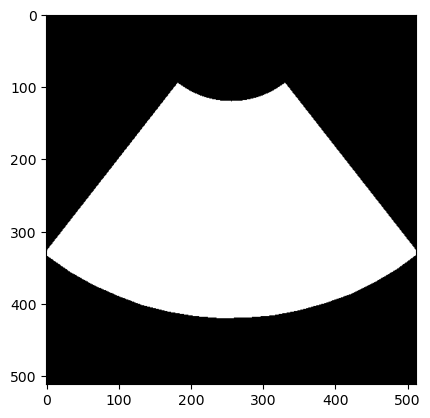

In [324]:
# Show the binary mask as an image

curvilinear_mask = curvilinear_mask(scanconversion_config)

plt.imshow(curvilinear_mask, cmap="gray")
plt.show()

In [325]:
import time

# Apply scan conversion to the ultrasound image and segmentation

x_cart, y_cart = scan_conversion_inverse(scanconversion_config)

converted_ultrasound_data = np.zeros((num_samples, scanconversion_config["num_lines"], scanconversion_config["num_samples_along_lines"]))
converted_segmentation_data = np.zeros((num_samples, scanconversion_config["num_lines"], scanconversion_config["num_samples_along_lines"]))

start_time = time.time()

for i in range(num_samples):
    converted_ultrasound_data[i, :, :] = map_coordinates(ultrasound_data[sample_indices[i], :, :, 0], [x_cart, y_cart], order=1, mode='constant', cval=0.0)
    converted_segmentation_data[i, :, :] = map_coordinates(segmentation_data[sample_indices[i], :, :, 0], [x_cart, y_cart], order=0, mode='constant', cval=0.0)

print(f"Scan conversion took {(time.time() - start_time)/num_samples * 1000} ms/frame.")
print()
print(f"converted_ultrasound_data.shape = {converted_ultrasound_data.shape}")
print(f"converted_ultrasound_data.dtype = {converted_ultrasound_data.dtype}")
print(f"converted_ultrasound_data.min = {converted_ultrasound_data.min()}")
print(f"converted_ultrasound_data.max = {converted_ultrasound_data.max()}")
print()
print(f"converted_segmentation_data.shape = {converted_segmentation_data.shape}")
print(f"converted_segmentation_data.dtype = {converted_segmentation_data.dtype}")
print(f"converted_segmentation_data.min = {converted_segmentation_data.min()}")
print(f"converted_segmentation_data.max = {converted_segmentation_data.max()}")
print()

print("Samples:")
for i in range(num_samples):
    print(f"Original index of sample {i}: {sample_indices[i]}")

Scan conversion took 1.0007619857788086 ms/frame.

converted_ultrasound_data.shape = (4, 128, 128)
converted_ultrasound_data.dtype = float64
converted_ultrasound_data.min = 0.0
converted_ultrasound_data.max = 255.0

converted_segmentation_data.shape = (4, 128, 128)
converted_segmentation_data.dtype = float64
converted_segmentation_data.min = 0.0
converted_segmentation_data.max = 1.0

Samples:
Original index of sample 0: 102
Original index of sample 1: 270
Original index of sample 2: 106
Original index of sample 3: 71


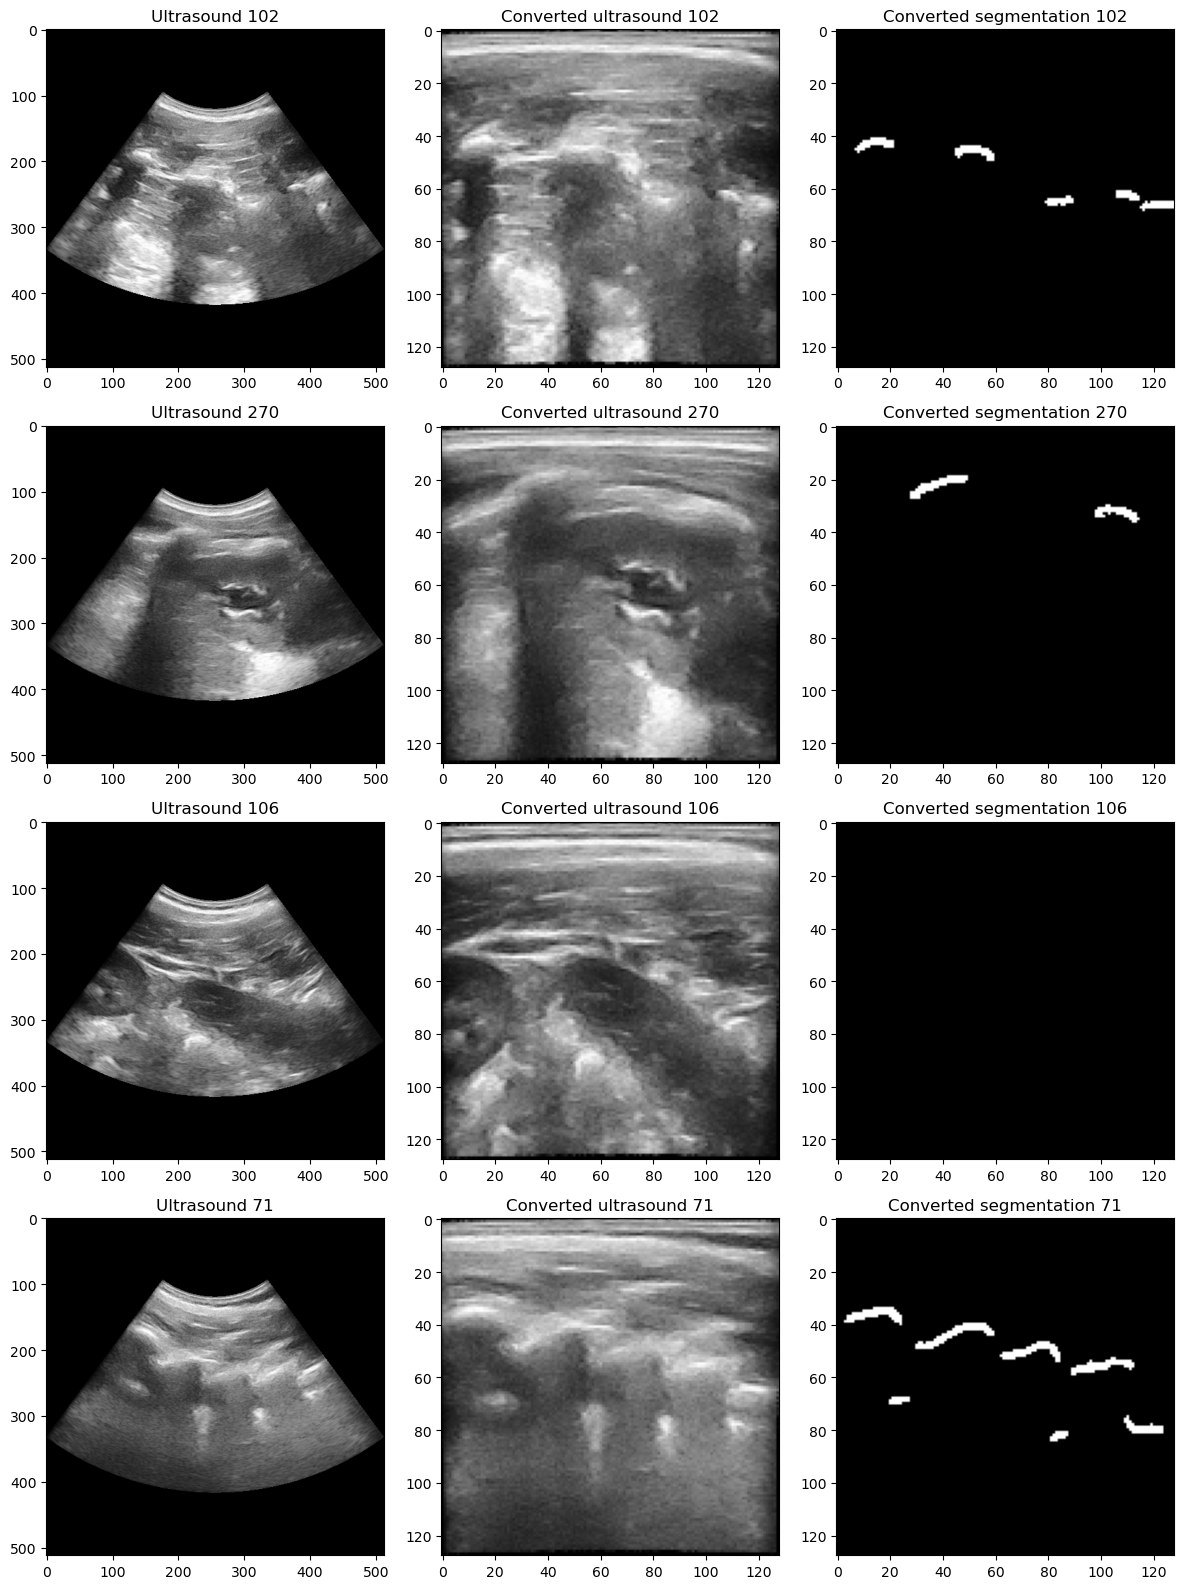

In [326]:
# Show the original image and converted images side by side

fig, ax = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for i, sample_index in enumerate(sample_indices):
    ax[i, 0].imshow(ultrasound_data[sample_index, :, :], cmap="gray")
    ax[i, 0].set_title(f"Ultrasound {sample_index}")
    ax[i, 1].imshow(converted_ultrasound_data[i, :, :], cmap="gray")
    ax[i, 1].set_title(f"Converted ultrasound {sample_index}")
    ax[i, 2].imshow(converted_segmentation_data[i, :, :], cmap="gray")
    ax[i, 2].set_title(f"Converted segmentation {sample_index}")

plt.tight_layout()
plt.show()

In [327]:
print("Measure scan conversion performance using griddata")
print()

from scipy.interpolate import griddata

# Create an empty image and segmentation image with the size of original ultrasound image

image_size = scanconversion_config["curvilinear_image_size"]


ultrasound_backconverted_data = np.zeros((num_samples, image_size, image_size), dtype=ultrasound_data.dtype)
segmentation_backconverted_data = np.zeros((num_samples, image_size, image_size), dtype=segmentation_data.dtype)

# Fill the empty image and segmentation image with the scan converted data

grid_x, grid_y = np.mgrid[0:image_size, 0:image_size]

start_time = time.time()

for i in range(num_samples):
    ultrasound_backconverted_data[i, :, :] = griddata((x_cart.flatten(), y_cart.flatten()),
                                                      converted_ultrasound_data[i, :, :].flatten(), (grid_x, grid_y), method="linear", fill_value=0)

print(f"Backconversion of ultrasound took {(time.time() - start_time)/num_samples * 1000} ms/frame")

start_time = time.time()

# Fill empty segmentations with the scan converted data and apply mask to prevent interpolation artifacts

for i in range(num_samples):
    segmentation_backconverted_data[i, :, :] = griddata((x_cart.flatten(), y_cart.flatten()),
                                                        converted_segmentation_data[i, :, :].flatten(), (grid_x, grid_y), method="nearest", fill_value=0)
    # segmentation_backconverted_data[i, :, :] = segmentation_backconverted_data[i, :, :] * curvilinear_mask

print(f"Backconversion of segmentation took {(time.time() - start_time)/num_samples * 1000} ms/frame")


Measure scan conversion performance using griddata

Backconversion of ultrasound took 137.7716064453125 ms/frame
Backconversion of segmentation took 214.39486742019653 ms/frame


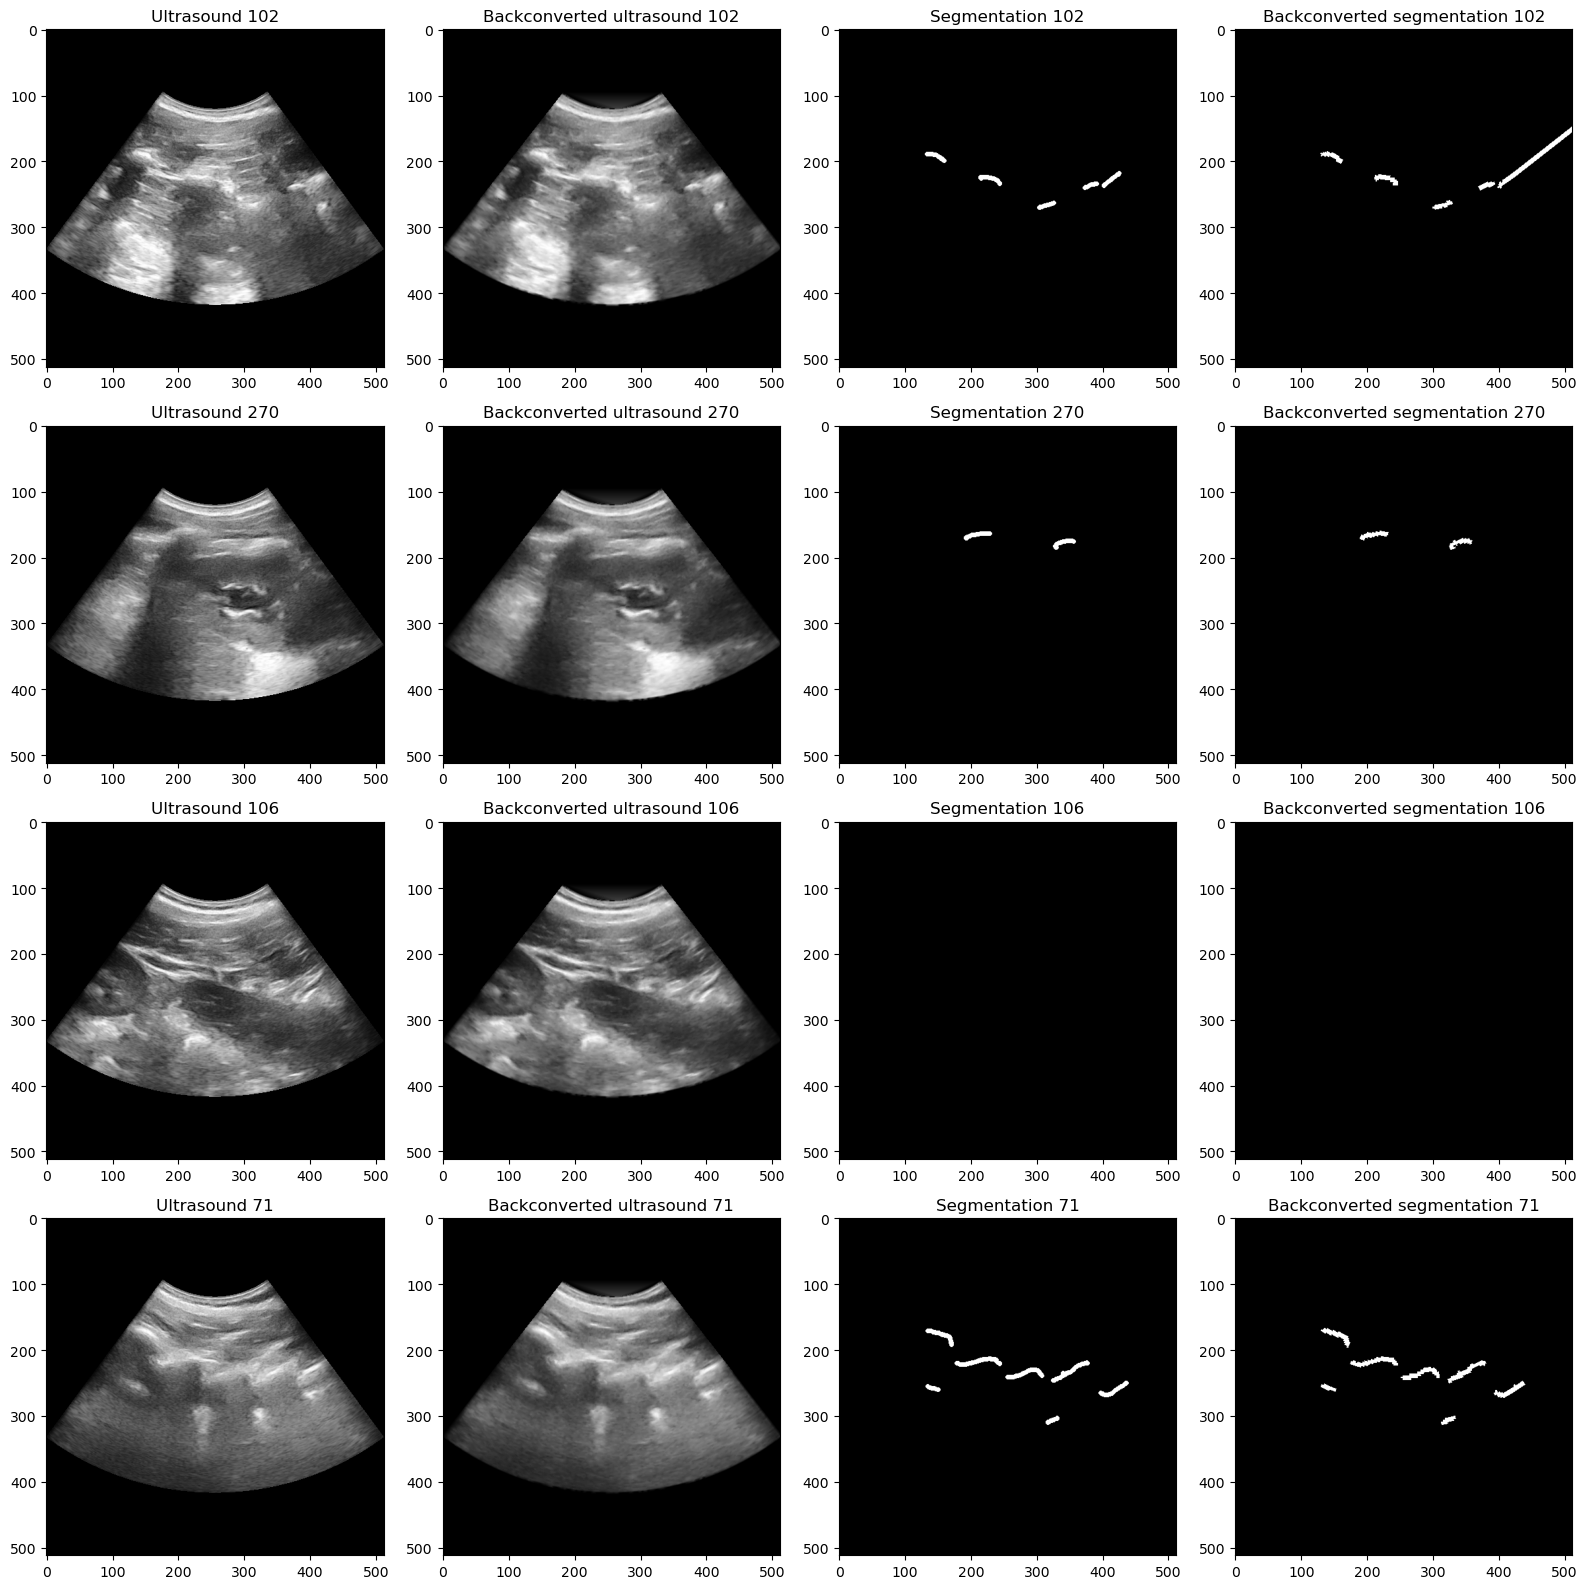

In [328]:
# Show images in four columns: original ultrasound, converted ultrasound, original segmentation, converted segmentation

fig, ax = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

for i, sample_index in enumerate(sample_indices):
    ax[i, 0].imshow(ultrasound_data[sample_indices[i], :, :], cmap="gray")
    ax[i, 0].set_title(f"Ultrasound {sample_index}")
    ax[i, 1].imshow(ultrasound_backconverted_data[i, :, :], cmap="gray")
    ax[i, 1].set_title(f"Backconverted ultrasound {sample_index}")
    ax[i, 2].imshow(segmentation_data[sample_indices[i], :, :], cmap="gray")
    ax[i, 2].set_title(f"Segmentation {sample_index}")
    ax[i, 3].imshow(segmentation_backconverted_data[i, :, :], cmap="gray")
    ax[i, 3].set_title(f"Backconverted segmentation {sample_index}")

plt.tight_layout()

x_cart.shape: (16, 16)
y_cart.shape: (16, 16)
random_indices: [110268 207892  54886 137337 213458 259286 168266  87498 112727 126324
 175203 191335  16023  41090  67221  64820    769  59735 194027  64925]



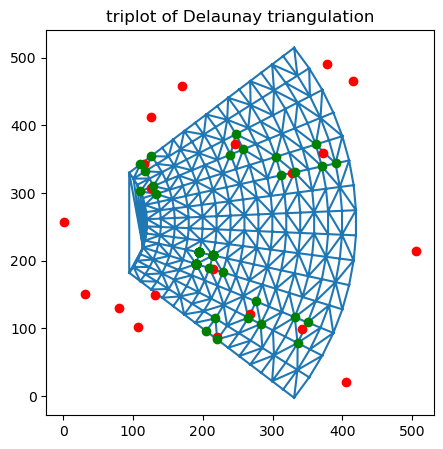

In [329]:
test_config = {
    "num_lines": 16,
    "num_samples_along_lines": 16,
    "curvilinear_image_size": 512,
    "center_coordinate_pixel": (0, 256),
    "radius_start_pixels": 120,
    "radius_end_pixels": 420,
    "angle_min_degrees": -38,
    "angle_max_degrees": 38
}


x_cart, y_cart = scan_conversion_inverse(test_config)

print(f"x_cart.shape: {x_cart.shape}")
print(f"y_cart.shape: {y_cart.shape}")

points = np.array([x_cart.flatten(), y_cart.flatten()]).T
from scipy.spatial import Delaunay
tri = Delaunay(points)

# Select random points on the output grid. Find the corresponding triangle among simplices and vertices.

num_image_points = 20
random_indices = np.random.randint(0, 512*512, num_image_points)
print(f"random_indices: {random_indices}")
print()

# Create an array that will hold the vertices coordinates of the triangles that contain the random points.

vertices_coordinates = np.zeros((num_image_points*3, 2), dtype=np.float32)

# Loop over the random points and find the corresponding triangle. Store the vertices coordinates of the triangle in the vertices_coordinates array.

for i in range(num_image_points):
    random_index = random_indices[i]
    random_point_coordinates = np.array([grid_x.flatten()[random_index], grid_y.flatten()[random_index]])
    
    random_vertices = tri.vertices[simplices[random_index], :]
    for j in range(3):
        vertices_coordinates[i*3 + j, :] = points[random_vertices[j], :]
    
    
# Plot the random points and the corresponding triangles on the grid.
# Plot vertices_coordinates using a different color to check that the vertices are correct.

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.triplot(points[:, 0], points[:, 1], tri.simplices)
ax.plot(grid_x.flatten()[random_indices], grid_y.flatten()[random_indices], 'o', color="red")
ax.plot(vertices_coordinates[:, 0], vertices_coordinates[:, 1], 'o', color="green")
ax.set_title('triplot of Delaunay triangulation')
plt.show()

weights.shape: (262144, 3)
z.shape: (16384,)
vertices.shape: (262144, 3)


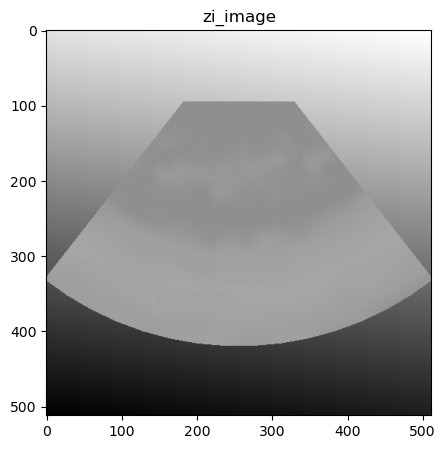

In [330]:
X = tri.transform[simplices, :2]
Y = np.vstack((grid_x.flatten(), grid_y.flatten())).T - tri.transform[simplices, 2]
b = np.einsum('ijk,ik->ij', X, Y)
weights = np.c_[b, 1 - b.sum(axis=1)]

print(f"weights.shape: {weights.shape}")
z = converted_ultrasound_data[0, :, :].flatten()

print(f"z.shape: {z.shape}")
print(f"vertices.shape: {vertices.shape}")

zi = np.einsum('ij,ij->i', np.take(z, vertices), weights)
# plot zi as an image

zi_image = zi.reshape((512, 512))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(zi_image, cmap="gray")
ax.set_title('zi_image')
plt.show()

In [331]:
print("Measure scan conversion performance using custom scan_conversion function")
print()

def scan_interpolation_weights(scanconversion_config):
    image_size = scanconversion_config["curvilinear_image_size"]

    x_cart, y_cart = scan_conversion_inverse(scanconversion_config)
    triangulation = Delaunay(np.vstack((x_cart.flatten(), y_cart.flatten())).T)

    grid_x, grid_y = np.mgrid[0:image_size, 0:image_size]
    simplices = triangulation.find_simplex(np.vstack((grid_x.flatten(), grid_y.flatten())).T)
    vertices = triangulation.simplices[simplices]

    X = triangulation.transform[simplices, :2]
    Y = np.vstack((grid_x.flatten(), grid_y.flatten())).T - triangulation.transform[simplices, 2]
    b = np.einsum('ijk,ik->ij', X, Y)
    weights = np.c_[b, 1 - b.sum(axis=1)]

    return vertices, weights


def scan_convert(linear_data, scanconversion_config, vertices, weights):
    """
    Scan convert a linear image to a curvilinear image.

    Args:
        linear_data (np.ndarray): Linear image to be scan converted.
        scanconversion_config (dict): Dictionary with scan conversion parameters.

    Returns:
        scan_converted_image (np.ndarray): Scan converted image.
    """
    
    z = linear_data.flatten()
    zi = np.einsum('ij,ij->i', np.take(z, vertices), weights)

    image_size = scanconversion_config["curvilinear_image_size"]
    return zi.reshape(image_size, image_size)


segmentation_data_float = (segmentation_data * 255).astype(np.float64)

print()
print(f"Value range of converted ultrasound data: {np.min(converted_ultrasound_data):.2f} - {np.max(converted_ultrasound_data):.2f}")
print(f"Data type of converted ultrasound data: {converted_ultrasound_data.dtype}")
# print(f"Value range of converted segmentation data: {np.min(segmentation_data):.2f} - {np.max(segmentation_data):.2f}")
print(f"Value range of converted segmentation data: {np.min(segmentation_data_float):.2f} - {np.max(segmentation_data_float):.2f}")
print(f"Data type of converted segmentation data: {segmentation_data_float.dtype}")
print()

# Create an empty image and segmentation image with the size of original ultrasound image

image_size = scanconversion_config["curvilinear_image_size"]

ultrasound_backconverted_data = np.zeros((num_samples, image_size, image_size), dtype=ultrasound_data.dtype)
segmentation_backconverted_data = np.zeros((num_samples, image_size, image_size), dtype=segmentation_data.dtype)

# Fill the empty image and segmentation image with the scan converted data

vertices, weights = scan_interpolation_weights(scanconversion_config)

start_time = time.time()

for i in range(num_samples):
    ultrasound_backconverted_data[i, :, :] = scan_convert(converted_ultrasound_data[i, :, :], scanconversion_config, vertices, weights)
    ultrasound_backconverted_data[i, :, :] = ultrasound_backconverted_data[i, :, :] * curvilinear_mask

elapsed_time_per_frame_ms = (time.time() - start_time)/num_samples * 1000
print(f"Backconversion of ultrasound took {elapsed_time_per_frame_ms:.2f} ms/frame")

start_time = time.time()

# Fill empty segmentations with the scan converted data and apply mask to prevent interpolation artifacts

for i in range(num_samples):
    segmentation_backconverted_data[i, :, :] = scan_convert(segmentation_data_float[i, :, :], scanconversion_config, vertices, weights)
    segmentation_backconverted_data[i, :, :] = segmentation_backconverted_data[i, :, :] * curvilinear_mask

elapsed_time_per_frame_ms = (time.time() - start_time)/num_samples * 1000
print(f"Backconversion of segmentation took {elapsed_time_per_frame_ms:.2f} ms/frame")
print()

print(f"Value range of ultrasound data: {np.min(ultrasound_backconverted_data):.2f} - {np.max(ultrasound_backconverted_data):.2f}")
print(f"Data type of ultrasound data: {ultrasound_backconverted_data.dtype}")
print(f"Value range of segmentation data: {np.min(segmentation_backconverted_data):.2f} - {np.max(segmentation_backconverted_data):.2f}")
print(f"Data type of segmentation data: {segmentation_backconverted_data.dtype}")

Measure scan conversion performance using custom scan_conversion function


Value range of converted ultrasound data: 0.00 - 255.00
Data type of converted ultrasound data: float64
Value range of converted segmentation data: 0.00 - 255.00
Data type of converted segmentation data: float64

Backconversion of ultrasound took 5.50 ms/frame
Backconversion of segmentation took 5.88 ms/frame

Value range of ultrasound data: 0.00 - 255.00
Data type of ultrasound data: uint8
Value range of segmentation data: 0.00 - 0.00
Data type of segmentation data: uint8


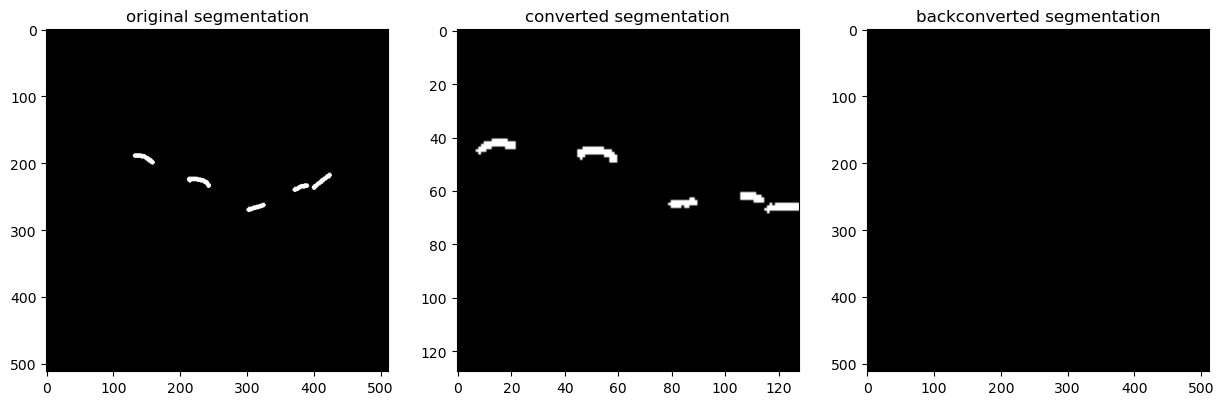

In [332]:
# Show segmentation data in three columns: original, converted, backconverted

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(segmentation_data[sample_indices[0], :, :], cmap="gray")
ax[0].set_title('original segmentation')
ax[1].imshow(converted_segmentation_data[0, :, :], cmap="gray")
ax[1].set_title('converted segmentation')
ax[2].imshow(segmentation_backconverted_data[0, :, :], cmap="gray")
ax[2].set_title('backconverted segmentation')
plt.show()

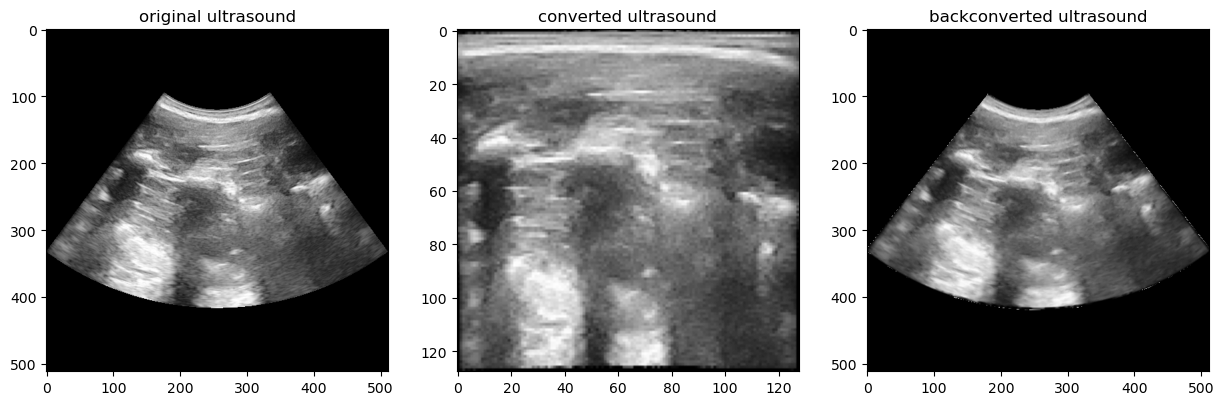

In [333]:
# Show images in three columns: original ultrasound, converted ultrasound, backconverted ultrasound

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ultrasound_data[sample_indices[0], :, :], cmap="gray")
ax[0].set_title('original ultrasound')
ax[1].imshow(converted_ultrasound_data[0, :, :], cmap="gray")
ax[1].set_title('converted ultrasound')
ax[2].imshow(ultrasound_backconverted_data[0, :, :], cmap="gray")
ax[2].set_title('backconverted ultrasound')
plt.show()

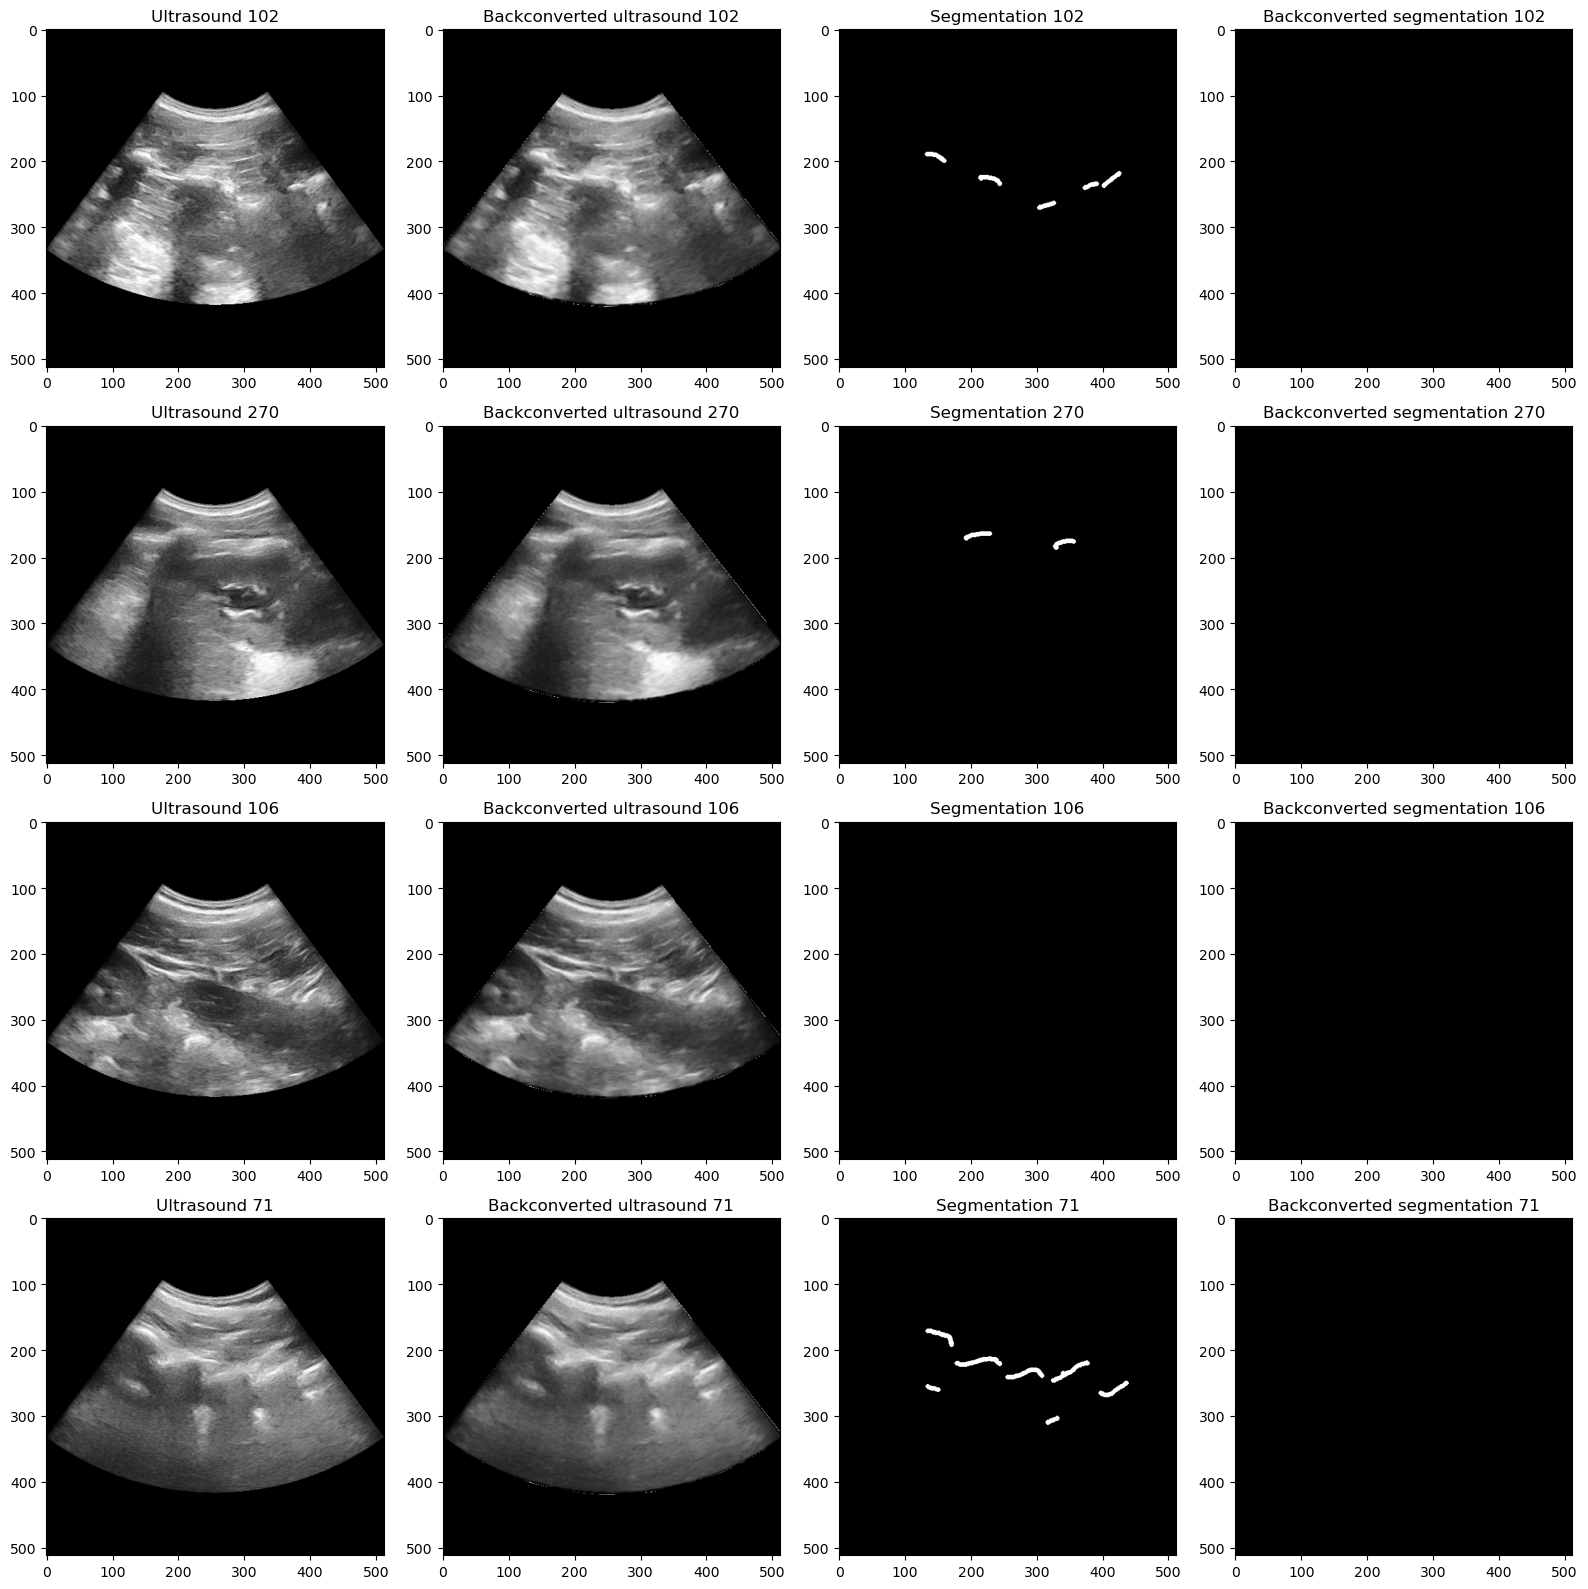

In [334]:
# Show images in four columns: original ultrasound, converted ultrasound, original segmentation, converted segmentation

fig, ax = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

for i, sample_index in enumerate(sample_indices):
    ax[i, 0].imshow(ultrasound_data[sample_indices[i], :, :], cmap="gray")
    ax[i, 0].set_title(f"Ultrasound {sample_index}")
    ax[i, 1].imshow(ultrasound_backconverted_data[i, :, :], cmap="gray")
    ax[i, 1].set_title(f"Backconverted ultrasound {sample_index}")
    ax[i, 2].imshow(segmentation_data[sample_indices[i], :, :], cmap="gray")
    ax[i, 2].set_title(f"Segmentation {sample_index}")
    ax[i, 3].imshow(segmentation_backconverted_data[i, :, :], cmap="gray")
    ax[i, 3].set_title(f"Backconverted segmentation {sample_index}")

plt.tight_layout()

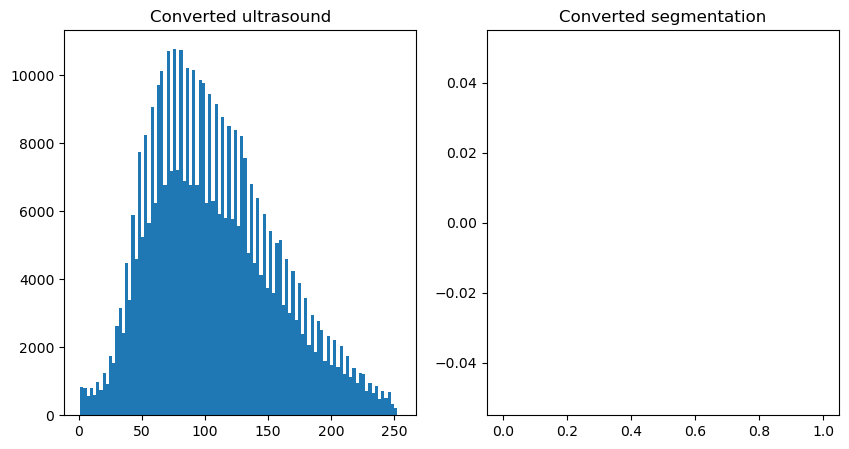

In [335]:
# Compute a histogram of the converted ultrasound image, excluding the background pixels
# Compute a histogram of the converted segmentation image, excluding the background pixels
# Plot the histograms side by side

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ultrasound_backconverted_data[ultrasound_backconverted_data > 0].flatten(), bins=100)
ax[0].set_title("Converted ultrasound")
ax[1].hist(segmentation_backconverted_data[segmentation_backconverted_data > 0].flatten(), bins=100)
ax[1].set_title("Converted segmentation")
plt.show()